In [96]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [97]:
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')

In [98]:
train_data = train_data.set_index('PassengerId')
test_data = test_data.set_index('PassengerId')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [99]:
train_data[train_data['Sex']== 'female']['Age'].median()
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [100]:
# this checks to see what the targets are
print(train_data['Survived'].value_counts())
print(train_data['Pclass'].value_counts())
print(train_data["Sex"].value_counts())
print(train_data["Embarked"].value_counts())

0    549
1    342
Name: Survived, dtype: int64
3    491
1    216
2    184
Name: Pclass, dtype: int64
male      577
female    314
Name: Sex, dtype: int64
S    644
C    168
Q     77
Name: Embarked, dtype: int64


In [101]:
# this is where we start our preprocessing
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('ordinal_encoder', OrdinalEncoder()),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('cat_encoder', OneHotEncoder(sparse_output=False))
])

In [102]:
num_attribs = ['Age', 'SibSp', 'Parch', 'Fare']
cat_attribs = ['Pclass', 'Sex', 'Embarked']

preprocess_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])

In [103]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[-0.56573646,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.66386103,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.1046374 ,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276197, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

In [104]:
# this gets the labels
y_train = train_data['Survived']

In [105]:
# we start training our model we will use a random forest classifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=69)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=69)

In [106]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = forest_clf.predict(X_test)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8115355805243446

In [107]:
svm_clf = SVC(gamma='auto')
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.8249313358302123

Text(0, 0.5, 'Accuracy')

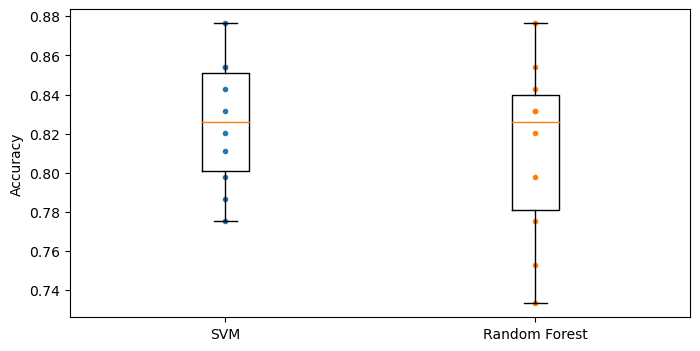

In [108]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, '.')
plt.plot([2]*10, forest_scores, '.')
plt.boxplot([svm_scores, forest_scores], labels=('SVM', 'Random Forest'))
plt.ylabel('Accuracy')

In [109]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [110]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(
    ['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000
